In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_14016\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [3]:
data=pd.read_csv("levelups_panel_20240722.csv",encoding='utf-8')

In [4]:
data = data[data['level_to'] <= 100]

In [5]:
data_ratio_term = data[['player_slug','binge', 'level_to', 'interval','total_purchase','total_ad']]

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['total_ad']
pivot_data_ratio = pivot_data_ratio.join(binge_series)

In [6]:
non_zero_ad_total_count = pivot_data_ratio[pivot_data_ratio['total_ad'] != 0].shape[0]
non_zero_ad_total_count

15292

In [7]:
filtered_df = pivot_data_ratio.dropna(subset=pivot_data_ratio.columns[:100])
non_zero_ad_total_count = filtered_df[filtered_df['total_ad'] != 0].shape[0]
non_zero_ad_total_count

5041

In [8]:
filtered_df

,2,3,4,5,6,7,8,9,10,11,...,92,93,94,95,96,97,98,99,100,total_ad
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,0.059167,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,0.041667,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0
2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,0.041944,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,0.042222,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,0.036667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,0.047500,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0
2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,0.037778,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,0.050833,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,0.0


In [9]:
# 각 컬럼별 null 값의 개수 계산
null_counts = pivot_data_ratio.isnull().sum()

# null 값의 개수를 데이터프레임으로 변환
null_counts_df = null_counts.to_frame('Null Count')

# null 값의 개수를 출력
print(null_counts_df)


          Null Count
2                  0
3                704
4               1371
5               1901
6               8438
...              ...
97             51256
98             51414
99             51734
100            52063
total_ad           0

[100 rows x 1 columns]


In [10]:
non_zero_ad_total_count = pivot_data_ratio[pivot_data_ratio['total_ad'] != 0]
non_zero_total_ad_count_value = pivot_data_ratio[pivot_data_ratio['total_ad'] != 0].shape[0]
print("Number of non zero total_ad: ", non_zero_total_ad_count_value)
filtered_df = non_zero_ad_total_count.dropna(subset=non_zero_ad_total_count.columns[:100])

Number of non zero total_ad:  15292


In [10]:
filtered_df.to_csv("full_lv100_0731_no_zeroad.csv",encoding='utf-8')

In [11]:
data=pd.read_csv("full_lv100_0731_no_zeroad.csv",encoding='utf-8')

In [12]:
filtered_df

,2,3,4,5,6,7,8,9,10,11,...,92,93,94,95,96,97,98,99,100,total_ad
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,0.041667,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0
2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,0.036667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0
2021-11-01T15:16:50.510Z,0.010000,0.011944,0.017500,0.027500,0.030000,0.028611,0.023611,0.026944,0.032500,0.042222,...,0.080222,0.055222,0.050000,0.070278,0.025278,0.045278,0.048333,0.051389,0.308667,85.0
2021-11-01T19:58:43.096Z,0.006944,0.003611,0.010833,0.010833,0.021944,0.020556,0.019444,0.053889,0.031111,0.040556,...,0.064722,0.067778,0.003056,0.064500,0.003611,0.041611,0.085556,0.020000,0.001667,6.0
2021-11-02T03:39:32.336Z,0.024722,0.006667,0.018056,0.033889,0.021944,0.022778,0.023056,0.028333,0.036111,0.046667,...,0.023889,0.011111,0.036389,0.003611,0.028889,0.057056,0.009722,0.003889,0.066778,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27T10:35:57.394Z,0.051389,0.006111,0.008333,0.015278,0.017500,0.034444,0.033222,0.044444,0.064722,0.063056,...,0.003333,0.042111,0.053778,0.000278,0.000278,0.000556,0.000278,0.000278,0.209222,1.0
2022-03-27T13:49:28.500Z,0.010278,0.004167,0.016944,0.019167,0.021944,0.029444,0.023611,0.032500,0.033611,0.045556,...,0.098056,0.095278,0.004722,0.084611,0.113611,0.136389,0.072500,0.065833,0.094444,5.0
2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,0.047500,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0


In [13]:
from sklearn.preprocessing import StandardScaler
# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
filtered_df['total_ad_normalized'] = scaler.fit_transform(filtered_df[['total_ad']])

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_14016\2963828096.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['total_ad_normalized'] = scaler.fit_transform(filtered_df[['total_ad']])


In [14]:
filtered_df['total_ad_normalized'].max()

23.301475724860968

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split


In [50]:
df= pd.read_csv('full_lv100_0731_no_zeroad.csv',encoding='utf-8')

In [51]:
df

,player_slug,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,total_ad
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0
1,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0
2,2021-11-01T15:16:50.510Z,0.010000,0.011944,0.017500,0.027500,0.030000,0.028611,0.023611,0.026944,0.032500,...,0.080222,0.055222,0.050000,0.070278,0.025278,0.045278,0.048333,0.051389,0.308667,85.0
3,2021-11-01T19:58:43.096Z,0.006944,0.003611,0.010833,0.010833,0.021944,0.020556,0.019444,0.053889,0.031111,...,0.064722,0.067778,0.003056,0.064500,0.003611,0.041611,0.085556,0.020000,0.001667,6.0
4,2021-11-02T03:39:32.336Z,0.024722,0.006667,0.018056,0.033889,0.021944,0.022778,0.023056,0.028333,0.036111,...,0.023889,0.011111,0.036389,0.003611,0.028889,0.057056,0.009722,0.003889,0.066778,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,2022-03-27T10:35:57.394Z,0.051389,0.006111,0.008333,0.015278,0.017500,0.034444,0.033222,0.044444,0.064722,...,0.003333,0.042111,0.053778,0.000278,0.000278,0.000556,0.000278,0.000278,0.209222,1.0
5037,2022-03-27T13:49:28.500Z,0.010278,0.004167,0.016944,0.019167,0.021944,0.029444,0.023611,0.032500,0.033611,...,0.098056,0.095278,0.004722,0.084611,0.113611,0.136389,0.072500,0.065833,0.094444,5.0
5038,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0
5039,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.028611,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,6.0


In [52]:
pivot_data_reset = df.melt(id_vars=['player_slug', 'total_ad'], var_name='level_to', value_name='interval')


In [53]:
pivot_data_reset

,player_slug,total_ad,level_to,interval
0,2021-11-01T10:41:53.949Z,28.0,2,0.020556
1,2021-11-01T15:10:02.121Z,2.0,2,0.006944
2,2021-11-01T15:16:50.510Z,85.0,2,0.010000
3,2021-11-01T19:58:43.096Z,6.0,2,0.006944
4,2021-11-02T03:39:32.336Z,26.0,2,0.024722
...,...,...,...,...
499054,2022-03-27T10:35:57.394Z,1.0,100,0.209222
499055,2022-03-27T13:49:28.500Z,5.0,100,0.094444
499056,2022-03-28T00:01:33.666Z,2.0,100,0.600833
499057,2022-03-29T09:29:33.653Z,6.0,100,0.102778


In [54]:
pivot_data_reset['color'] = pivot_data_reset['total_ad'].apply(lambda x: 'blue' if x == 0 else 'red')
# 그래프 그리기


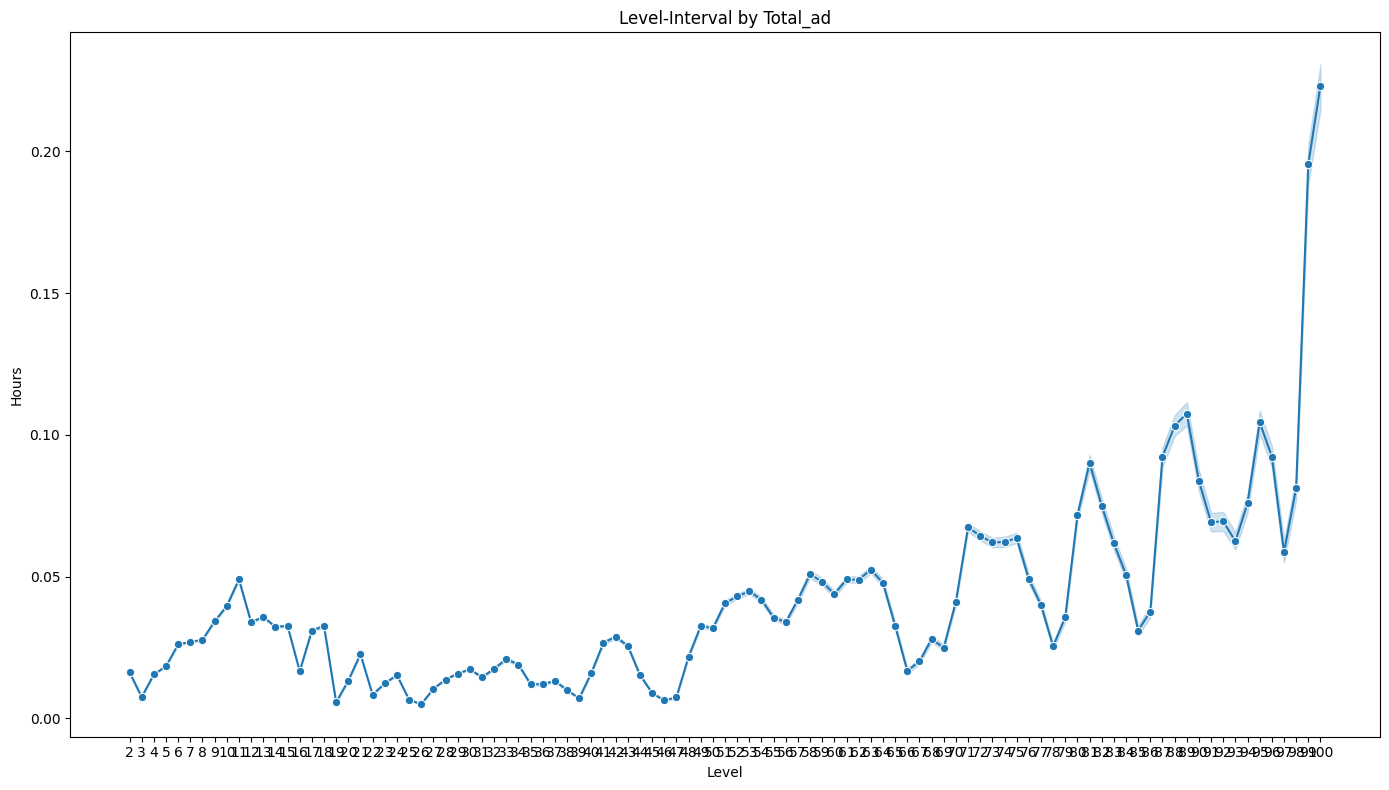

In [55]:
import seaborn as sns
# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_data_reset, x='level_to', y='interval', hue='color', marker='o', legend=False)

# 플롯 커스터마이징
plt.title('Level-Interval by Total_ad')
plt.xlabel('Level')
plt.ylabel('Hours')

# 플롯 표시
plt.tight_layout()
plt.show()

In [56]:
lower_bound = filtered_df['total_ad'].quantile(0.3)
upper_bound = filtered_df['total_ad'].quantile(0.95)

# Filter the DataFrame to remove the top 5% and bottom 5%

#df = filtered_df[(filtered_df['total_ad'] < upper_bound)]
df=filtered_df


In [57]:
# 'player_slug' 인덱스를 열로 변환
df = df.reset_index()

# 결과 확인
print(df.head())

                player_slug         2         3         4         5         6  \
0  2021-11-01T10:41:53.949Z  0.020556  0.004167  0.006111  0.006667  0.019722   
1  2021-11-01T15:10:02.121Z  0.006944  0.003611  0.010833  0.015000  0.023056   
2  2021-11-01T15:16:50.510Z  0.010000  0.011944  0.017500  0.027500  0.030000   
3  2021-11-01T19:58:43.096Z  0.006944  0.003611  0.010833  0.010833  0.021944   
4  2021-11-02T03:39:32.336Z  0.024722  0.006667  0.018056  0.033889  0.021944   

          7         8         9        10  ...        93        94        95  \
0  0.021389  0.023056  0.030278  0.032778  ...  0.003889  0.123833  0.095833   
1  0.022778  0.022500  0.048333  0.031667  ...  0.129722  0.004167  0.199111   
2  0.028611  0.023611  0.026944  0.032500  ...  0.055222  0.050000  0.070278   
3  0.020556  0.019444  0.053889  0.031111  ...  0.067778  0.003056  0.064500   
4  0.022778  0.023056  0.028333  0.036111  ...  0.011111  0.036389  0.003611   

         96        97        98 

In [58]:
df

,player_slug,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,total_ad,total_ad_normalized
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0,0.237257
1,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0,-0.385453
2,2021-11-01T15:16:50.510Z,0.010000,0.011944,0.017500,0.027500,0.030000,0.028611,0.023611,0.026944,0.032500,...,0.055222,0.050000,0.070278,0.025278,0.045278,0.048333,0.051389,0.308667,85.0,1.602428
3,2021-11-01T19:58:43.096Z,0.006944,0.003611,0.010833,0.010833,0.021944,0.020556,0.019444,0.053889,0.031111,...,0.067778,0.003056,0.064500,0.003611,0.041611,0.085556,0.020000,0.001667,6.0,-0.289652
4,2021-11-02T03:39:32.336Z,0.024722,0.006667,0.018056,0.033889,0.021944,0.022778,0.023056,0.028333,0.036111,...,0.011111,0.036389,0.003611,0.028889,0.057056,0.009722,0.003889,0.066778,26.0,0.189356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,2022-03-27T10:35:57.394Z,0.051389,0.006111,0.008333,0.015278,0.017500,0.034444,0.033222,0.044444,0.064722,...,0.042111,0.053778,0.000278,0.000278,0.000556,0.000278,0.000278,0.209222,1.0,-0.409404
5037,2022-03-27T13:49:28.500Z,0.010278,0.004167,0.016944,0.019167,0.021944,0.029444,0.023611,0.032500,0.033611,...,0.095278,0.004722,0.084611,0.113611,0.136389,0.072500,0.065833,0.094444,5.0,-0.313602
5038,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0,-0.385453
5039,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,6.0,-0.289652


In [59]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# total_purchase가 포함된 행만 선택
# total_purchase가 포함된 행만 선택
df = df.drop(columns=['player_slug'])

df = df.dropna(subset=['total_ad'])

# X (타임라인 데이터)와 y (total_purchase) 분리
y = df['total_ad'].values
X = df.drop(columns=['total_ad'])
# 함수형 데이터 객체 생성
argvals = np.arange(X.shape[1])
fd = FDataGrid(data_matrix=X.values, grid_points=argvals)

# 데이터 스케일링 및 B-spline 기반 스무딩
scaler = StandardScaler()
basis = BSplineBasis(n_basis=10)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)


In [60]:
# FPCA 적용
fpca = FPCA(n_components=3)
fd_fpca = fpca.fit_transform(fd_smooth)

# 주성분 설명 분산
explained_variance = fpca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance)


Explained variance ratio by each component: [0.87683405 0.11252795 0.00883603]


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_14016\3674483969.py:3: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the functional data object instead.
  plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')


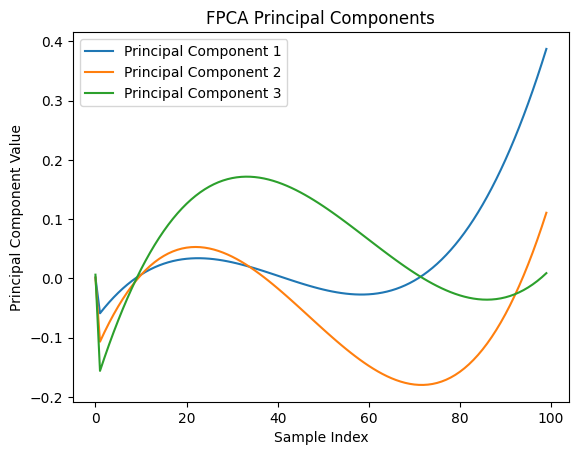

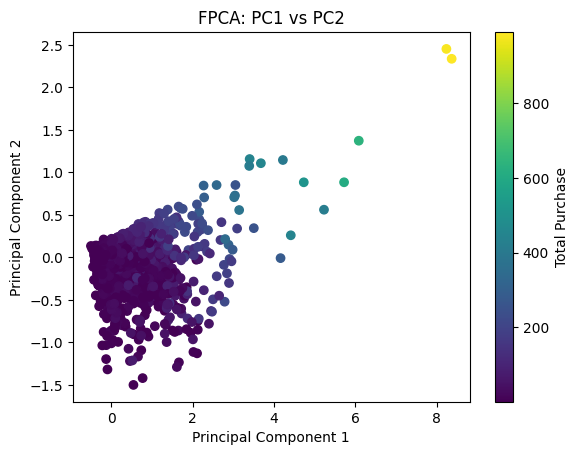

In [61]:
# 주성분 시각화
for i in range(3):
    plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')

plt.xlabel('Sample Index')
plt.ylabel('Principal Component Value')
plt.title('FPCA Principal Components')
plt.legend()
plt.show()



# 주성분 점수 플롯
plt.scatter(fd_fpca[:, 0], fd_fpca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('FPCA: PC1 vs PC2')
plt.colorbar(label='Total Purchase')
plt.show()


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


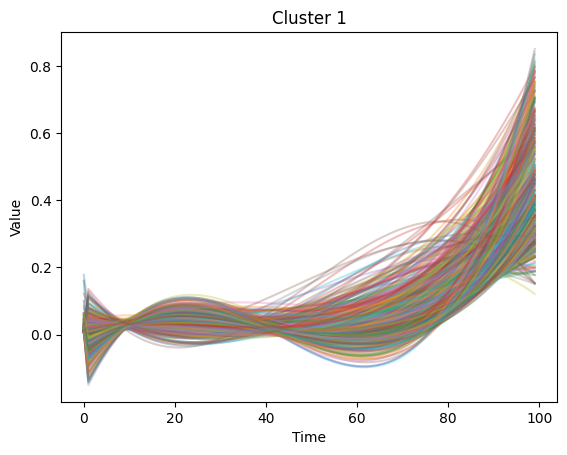

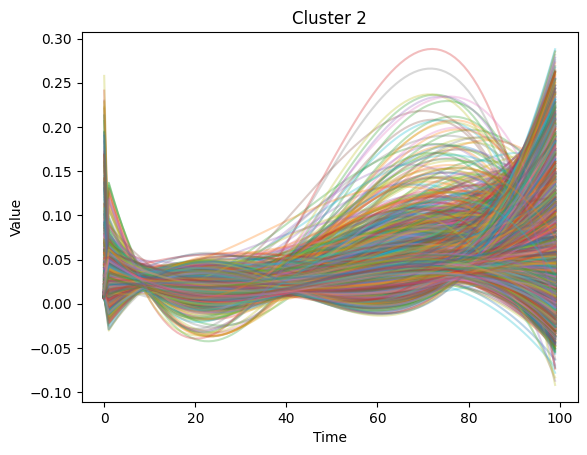

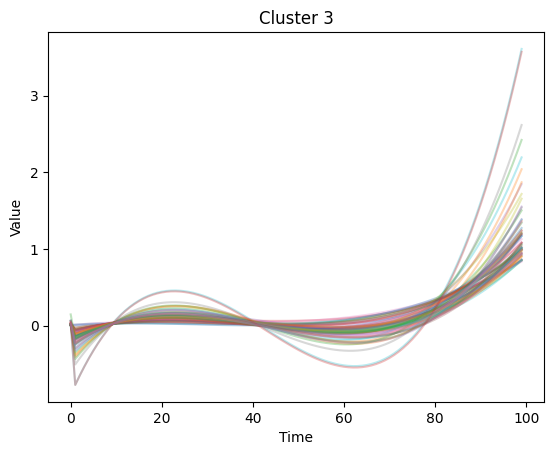

Cluster labels: [1 1 0 ... 1 1 1]


In [62]:

# 함수형 K-평균 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=123)
labels = kmeans.fit_predict(fd_fpca)

# 클러스터링 결과 시각화
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    plt.figure()
    for index in cluster_indices:
        plt.plot(argvals, fd_smooth.data_matrix[index].flatten(), alpha=0.3)
    plt.title(f'Cluster {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# 클러스터 할당 결과 확인
print("Cluster labels:", labels)

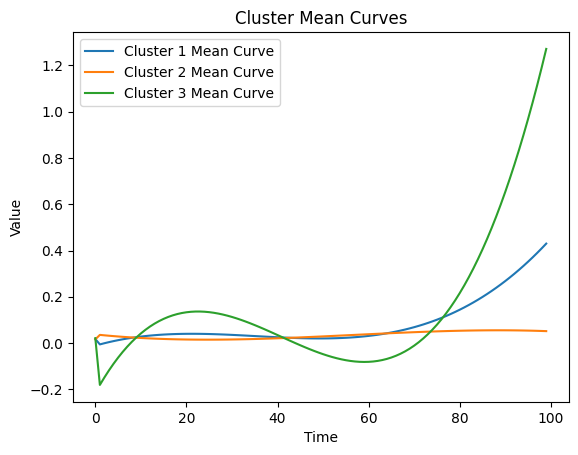

In [63]:
# 클러스터별 평균 곡선 계산 및 시각화
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    cluster_data = fd_smooth.data_matrix[cluster_indices]
    mean_curve = np.mean(cluster_data, axis=0).flatten()
    plt.plot(argvals, mean_curve, label=f'Cluster {i + 1} Mean Curve')
plt.title('Cluster Mean Curves')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [64]:
# FPCA 주성분을 DataFrame으로 변환
fpca_df = pd.DataFrame(fd_fpca, columns=[f'PC{i+1}' for i in range(fd_fpca.shape[1])])


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              6038.
Date:                Fri, 02 Aug 2024   Prob (F-statistic):                        0.00
Time:                        12:42:00   Log-Likelihood:                         -1949.0
No. Observations:                3528   AIC:                                      3904.
Df Residuals:                    3525   BIC:                                      3922.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

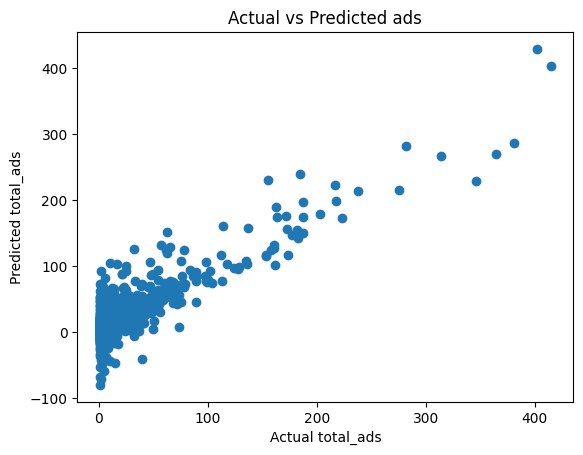

In [66]:
# 데이터 분할 (훈련/테스트)
from sklearn.metrics import r2_score

# total_purchase 값을 기준으로 stratify 배열 생성
#y_stratify = (y > 0).astype(int)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 데이터 분할 (훈련/테스트)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(fd_fpca, y_scaled, test_size=0.3, random_state=110)

# OLS 모델 적합
model = OLS(y_train_scaled, X_train).fit()

# 모델 요약 출력
print(model.summary())


# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 예측값 역변환
y_pred = y_scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
y_test = y_scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1)).flatten()
# 예측값이 0보다 작지 않도록 조정
#y_pred = np.maximum(y_pred, 0)

# R-squared 값 계산
r_squared = r2_score(y_test, y_pred)
#print(f'R-squared: {r_squared}')

# 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel("Actual total_ads")
plt.ylabel("Predicted total_ads")
plt.title("Actual vs Predicted ads")
plt.show()

In [47]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')


R-squared: 0.7743358664522185
